# Ensemble Kalman Filter with Lorenz 63 System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

from src.lorenz_systems.lorenz63 import solve_lorenz63
from src.lorenz_systems.enkf import EnsembleKalmanFilter

In [2]:
# Generate true trajectory
xyz0_true = np.array([0., 1., 1.05])
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 500)
true_sol = solve_lorenz63(xyz0_true, t_span, t_eval)

# Create noisy observations
R_true = np.eye(3) * 2.0  # Observation noise covariance
y = true_sol.y + np.random.multivariate_normal(np.zeros(3), R_true, len(t_eval)).T

In [3]:
# Initialize EnKF
N = 20  # Number of ensemble members
enkf = EnsembleKalmanFilter(model=solve_lorenz63, R=R_true, N=N)

# Initial ensemble
X0 = np.random.multivariate_normal(xyz0_true, np.eye(3) * 1.0, N).T

In [4]:
# Run the EnKF
X_hist = [X0]
x_mean_hist = [np.mean(X0, axis=1)]

for i in range(1, len(t_eval)):
    t_step_span = [t_eval[i-1], t_eval[i]]
    t_step_eval = np.array([t_eval[i]])
    
    # Forecast
    X_f = enkf.forecast(X_hist[-1], t_step_span, t_step_eval)
    
    # Analysis
    X_a = enkf.analysis(X_f, y[:, i], H=np.eye(3))
    
    X_hist.append(X_a)
    x_mean_hist.append(np.mean(X_a, axis=1))

x_mean_hist = np.array(x_mean_hist)

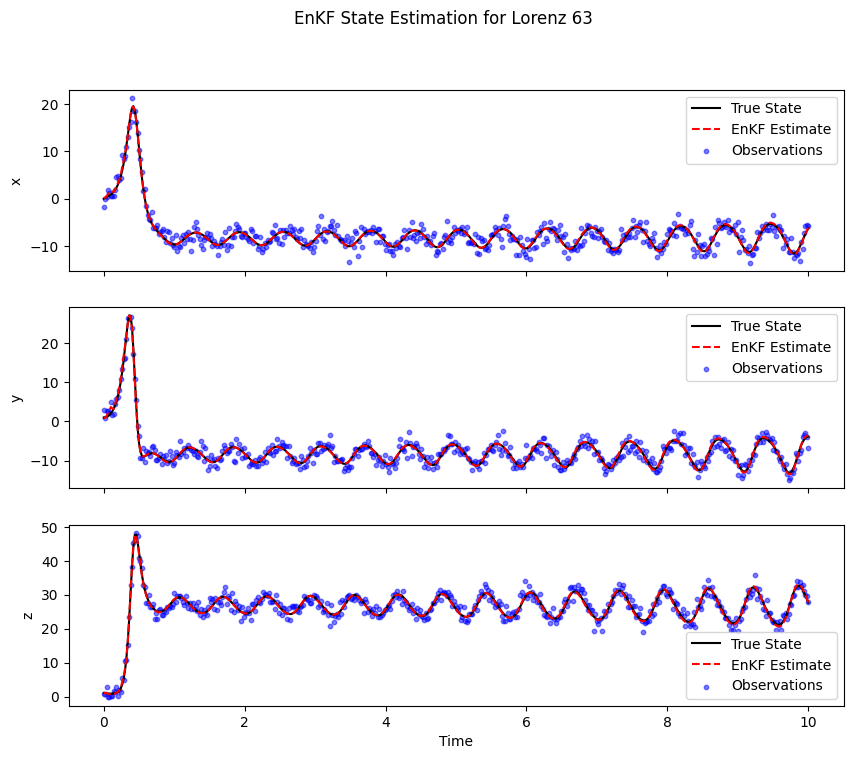

In [5]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, label in enumerate(['x', 'y', 'z']):
    axes[i].plot(t_eval, true_sol.y[i, :], 'k-', label='True State')
    axes[i].plot(t_eval, x_mean_hist[:, i], 'r--', label='EnKF Estimate')
    axes[i].scatter(t_eval, y[i, :], s=10, c='b', marker='o', label='Observations', alpha=0.5)
    axes[i].set_ylabel(label)
    axes[i].legend()

axes[-1].set_xlabel('Time')
fig.suptitle('EnKF State Estimation for Lorenz 63')
plt.show()